In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics, calibration
from sklearn.preprocessing import binarize, normalize
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from sklearn.ensemble import GradientBoostingClassifier
from collections import OrderedDict
import sys
sys.path.insert(1, '..')
import utils
import json
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [2]:
col_exclued = ""
model = "captur"
col_keep = ""

### Diretório contendo as bases

In [3]:
data_folder = '../../data/data_other_models'

### Lendo base do modelo e o arquivo json contendo configurações de features que serão utilizados

In [4]:
data = pd.read_csv(f'{data_folder}/nam_vme_{model}.csv')
with open(f'{data_folder}/features_utils_taxa_gr_zero.json') as f:
   data_json = json.load(f)


### Filtrando base para trabalhar apenas com taxa não zero e criando os bins

In [5]:
data_new = data.copy()
data_new = data_new[data_new.rci_offer == 'promo rate >0%']
data_new['percen_label'] = data_new['nam_before_kickback_unique'] / data_new['VME_Rate_Bonification']

In [6]:
bins = [-3, 1, 2, 3, 4, 5, 10, 15, 200]

In [7]:
dat_bins = utils.create_bins(data_new.percen_label, bins)

In [8]:
data_new['bins'] = dat_bins

In [9]:
data_new['bins'] = data_new.bins.astype(int)

In [10]:
data_new.bins.value_counts()

3      959
10     599
4      509
2      444
5      243
200    189
1      145
15      96
Name: bins, dtype: int64

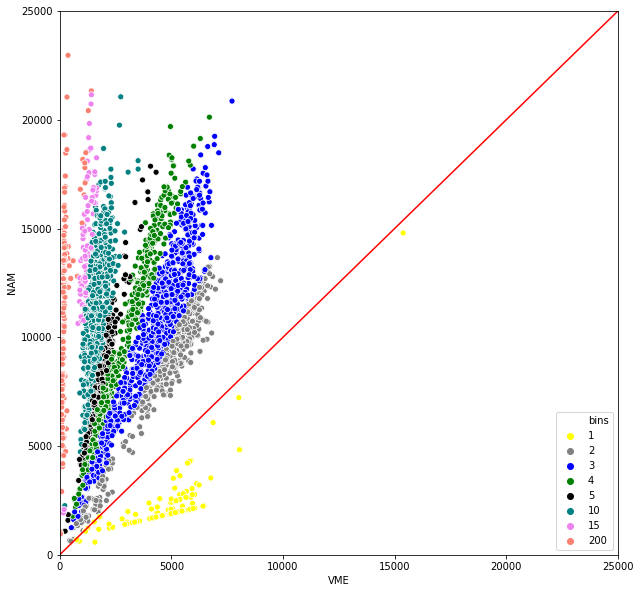

In [11]:
#data_new['indicator_final'] = data_new.apply(mapear_cor, axis=1)
#PALLETE = ['yellow', 'grey', 'blue', 'green', 'black']
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="VME_Rate_Bonification", y="nam_before_kickback_unique",hue="bins",
                     data=data_new, palette=['yellow', 'grey', 'blue', 'green', 'black', 'teal', 'violet', 'salmon'])

plt.plot([0, 40000], [0, 40000], 'k-', color = 'r')
plt.xlabel('VME')
plt.ylabel('NAM')
plt.xlim([0,25000])
plt.ylim([0,25000])
plt.show()

### Trial 1
    - bin 1: classe 1
    - bin 2 e 3: classe 0

In [12]:
dat_model = data_new[data_new.bins.isin([1,2,3])]

In [13]:
dat_model['label'] = np.where((dat_model.bins == 1), 1, 0)

In [14]:
dat_model.label.value_counts()

0    1403
1     145
Name: label, dtype: int64

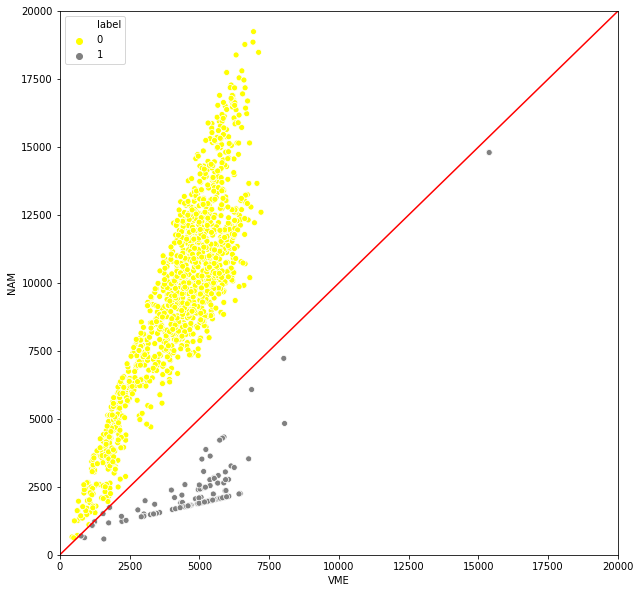

In [15]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="VME_Rate_Bonification", y="nam_before_kickback_unique", hue="label",
                     data=dat_model, palette=['yellow', 'gray'])

plt.plot([0, 20000], [0, 20000], 'k-', color = 'r')
plt.xlabel('VME')
plt.ylabel('NAM')
plt.xlim([0,20000])
plt.ylim([0,20000])
plt.show()

In [16]:
dat_model['srgk_time_real'] = pd.to_datetime(dat_model['srgk_time_real'], format='%Y%m%d')

In [17]:
dat_model['year'] = dat_model['srgk_time_real'].dt.year

In [18]:
dat_model['dayofweek'] = dat_model['srgk_time_real'].dt.dayofweek
dat_model['quarter'] = dat_model['srgk_time_real'].dt.quarter
dat_model['month'] = dat_model['srgk_time_real'].dt.month
dat_model['dayofyear'] = dat_model['srgk_time_real'].dt.dayofyear
dat_model['dayofmonth'] = dat_model['srgk_time_real'].dt.day
dat_model['weekofyear'] = dat_model['srgk_time_real'].dt.weekofyear

### Regra da cidade: caso a cidade possui menos que 10 vendas, substitui o nome da cidade por 'outros'.
### Encodar todas as variáveis pertencentes ao COLS_ENCODED.

In [19]:
dici_values = dat_model['name_city'].value_counts()
dat_model['name_city_renew'] = dat_model.name_city.apply(lambda x: x if dici_values[x] > 10 else 'outros')
data_new = pd.concat([dat_model, pd.get_dummies(dat_model[data_json['models'][model]['cols_encoded']])], axis=1).reset_index(drop=True)
label = data_new.label

### Obter a lista de variáveis que serão utilizados no modelo

In [20]:
COLS = list(data_new.columns)
COLS_AUX = ['bins']
if not col_exclued:
    for col in data_json['models'][model]['cols_encoded'] + data_json['models'][model]['cols_excluded'] + COLS_AUX:     
        COLS.remove(col)
        
else: 
    for col in data_json['models'][model]['cols_encoded'] + data_json['models'][model]['cols_excluded'] + COLS_AUX + col_exclued:
        COLS.remove(col)

        
if col_keep: 
    COLS.append(col_keep)
    

In [21]:
len(COLS)

207

### Separação treino e teste

In [22]:
#X_train, X_test, y_train, y_test = train_test_split(data_new, label, test_size=0.3, random_state=42)

In [23]:
#X_train.shape , X_test.shape

Fold: 0
{'0': {'precision': 0.99644128113879, 'recall': 0.99644128113879, 'f1-score': 0.99644128113879, 'support': 281}, '1': {'precision': 0.9655172413793104, 'recall': 0.9655172413793104, 'f1-score': 0.9655172413793104, 'support': 29}, 'accuracy': 0.9935483870967742, 'macro avg': {'precision': 0.9809792612590502, 'recall': 0.9809792612590502, 'f1-score': 0.9809792612590502, 'support': 310}, 'weighted avg': {'precision': 0.9935483870967742, 'recall': 0.9935483870967742, 'f1-score': 0.9935483870967742, 'support': 310}}


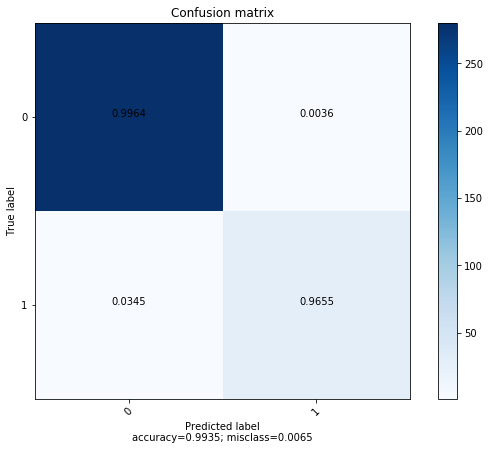

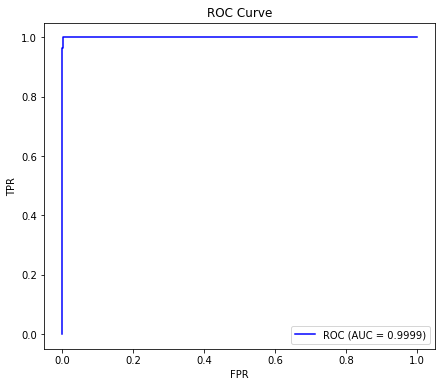

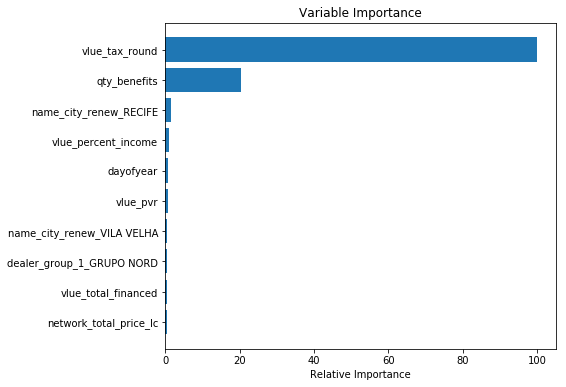

Fold: 1
{'0': {'precision': 0.9964539007092199, 'recall': 1.0, 'f1-score': 0.9982238010657194, 'support': 281}, '1': {'precision': 1.0, 'recall': 0.9655172413793104, 'f1-score': 0.9824561403508771, 'support': 29}, 'accuracy': 0.9967741935483871, 'macro avg': {'precision': 0.99822695035461, 'recall': 0.9827586206896552, 'f1-score': 0.9903399707082983, 'support': 310}, 'weighted avg': {'precision': 0.9967856325783575, 'recall': 0.9967741935483871, 'f1-score': 0.9967487618375568, 'support': 310}}


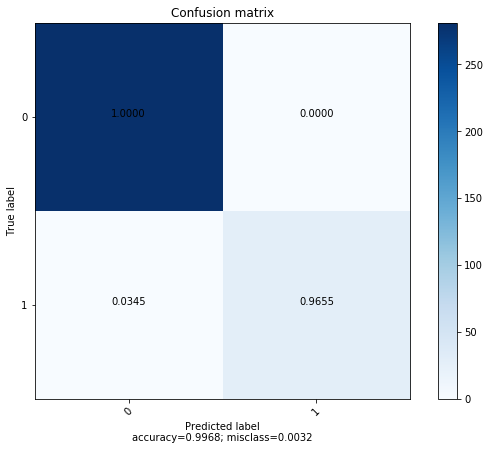

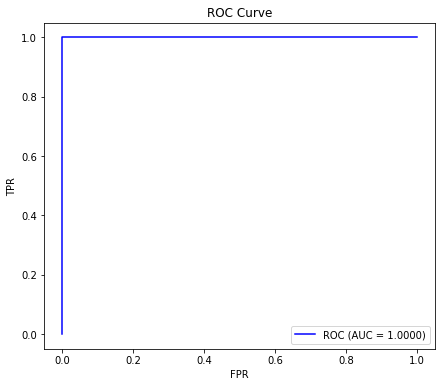

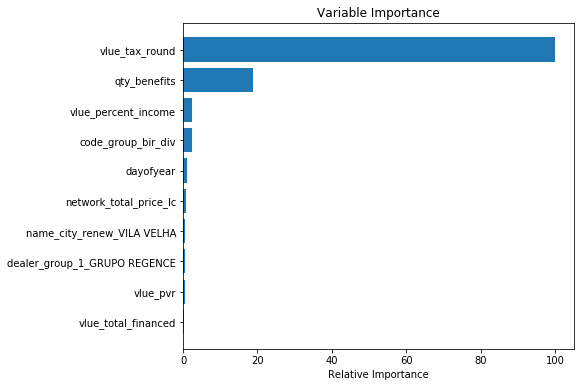

Fold: 2
{'0': {'precision': 0.9894366197183099, 'recall': 1.0, 'f1-score': 0.9946902654867256, 'support': 281}, '1': {'precision': 1.0, 'recall': 0.896551724137931, 'f1-score': 0.9454545454545454, 'support': 29}, 'accuracy': 0.9903225806451613, 'macro avg': {'precision': 0.994718309859155, 'recall': 0.9482758620689655, 'f1-score': 0.9700724054706356, 'support': 310}, 'weighted avg': {'precision': 0.9904248069059518, 'recall': 0.9903225806451613, 'f1-score': 0.9900843432901667, 'support': 310}}


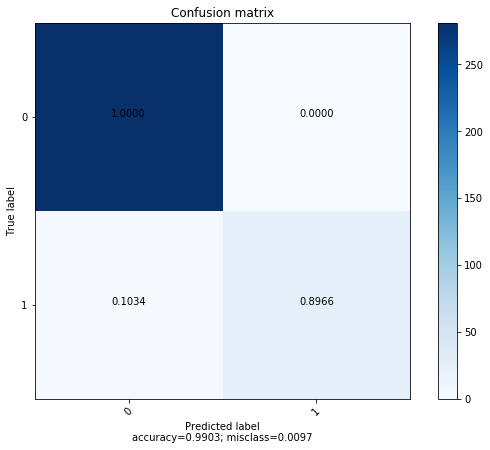

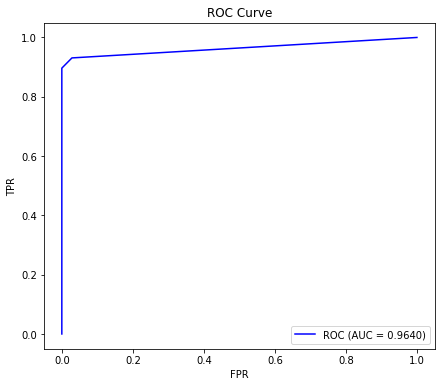

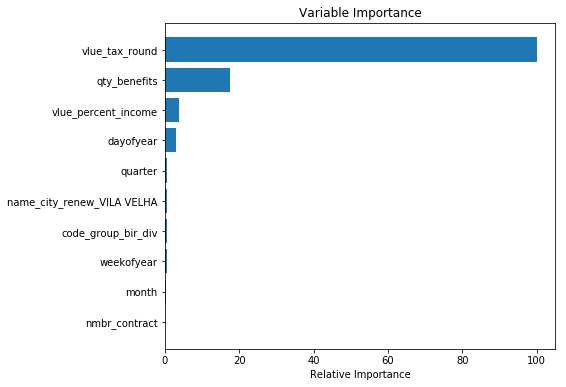

Fold: 3
{'0': {'precision': 0.9963636363636363, 'recall': 0.9785714285714285, 'f1-score': 0.9873873873873874, 'support': 280}, '1': {'precision': 0.8235294117647058, 'recall': 0.9655172413793104, 'f1-score': 0.888888888888889, 'support': 29}, 'accuracy': 0.9773462783171522, 'macro avg': {'precision': 0.9099465240641711, 'recall': 0.9720443349753695, 'f1-score': 0.9381381381381382, 'support': 309}, 'weighted avg': {'precision': 0.9801429486181057, 'recall': 0.9773462783171522, 'f1-score': 0.9781431917354247, 'support': 309}}


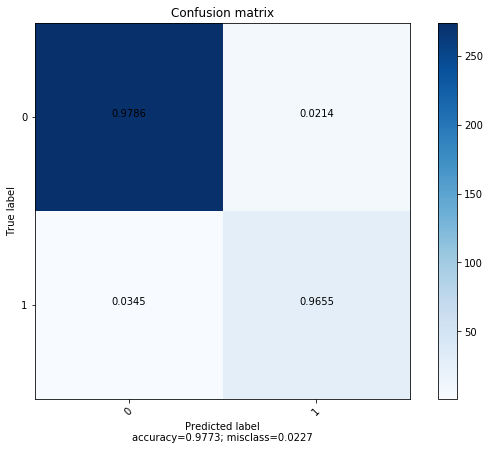

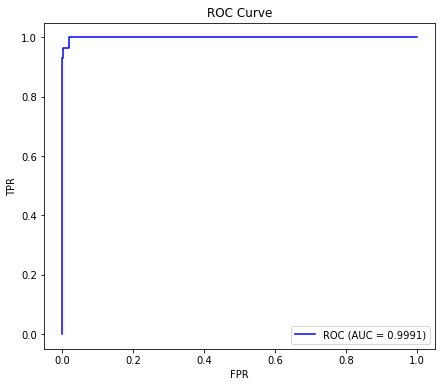

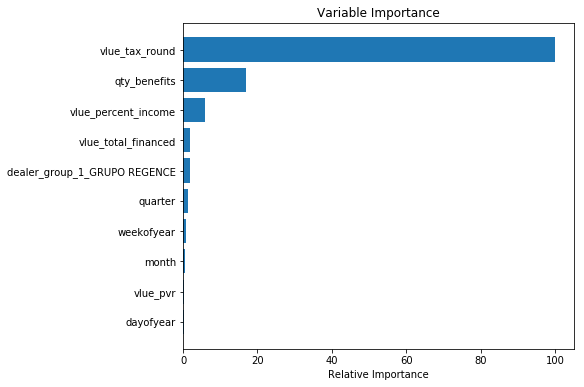

Fold: 4
{'0': {'precision': 0.9851301115241635, 'recall': 0.9464285714285714, 'f1-score': 0.965391621129326, 'support': 280}, '1': {'precision': 0.625, 'recall': 0.8620689655172413, 'f1-score': 0.7246376811594203, 'support': 29}, 'accuracy': 0.9385113268608414, 'macro avg': {'precision': 0.8050650557620818, 'recall': 0.9042487684729064, 'f1-score': 0.8450146511443731, 'support': 309}, 'weighted avg': {'precision': 0.951331492643255, 'recall': 0.9385113268608414, 'f1-score': 0.9427965911645129, 'support': 309}}


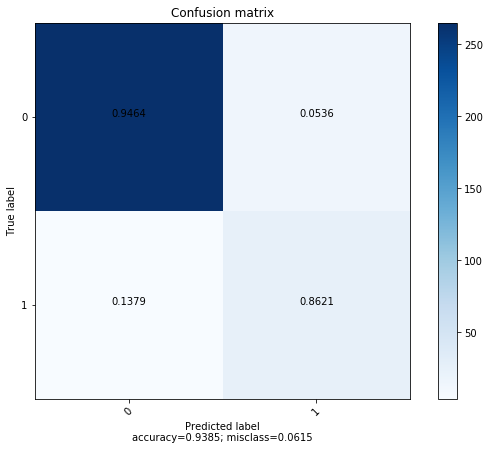

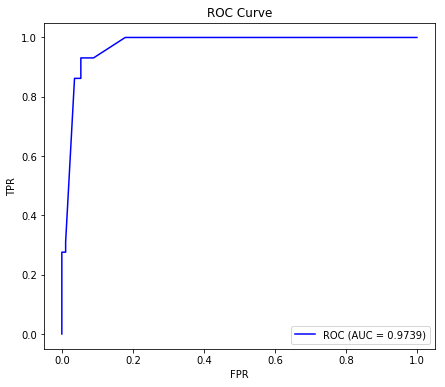

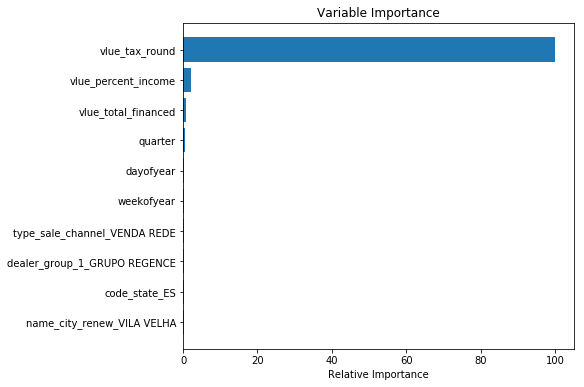

In [24]:
skf = StratifiedKFold(n_splits=5)
for idx, (train_index, test_index) in enumerate(skf.split(data_new, label)):
    print(f'Fold: {idx}')
    X_train, X_test = data_new.iloc[train_index], data_new.iloc[test_index]
    y_train, y_test = label.iloc[train_index], label.iloc[test_index]
    
    clf = GradientBoostingClassifier(random_state=42, n_estimators=100)
    clf.fit(X_train[COLS].fillna(-999), y_train)
    
    proba_predicted = clf.predict_proba(X_test[COLS].fillna(-999))[:,1]
    expected = y_test
    threshold = utils.best_threshold(expected, proba_predicted)
    row_proba_predicted = proba_predicted.reshape(1, -1)
    predicted = binarize(row_proba_predicted, threshold).reshape(-1, 1)
    
    str_rep = utils.metrics.classification_report(expected, predicted, digits=4, output_dict=True)
    print(str_rep)
    
    utils.plot_confusion_matrix(metrics.confusion_matrix(expected, predicted), target_names=['0','1'], normalize=True)
    
    utils.compute_roc(expected, proba_predicted, plot=True)
    
    utils.feature_importance(clf, X_train[COLS].keys())

In [27]:
from sklearn.tree import export_text

In [34]:
from xgboost import XGBClassifier

In [35]:
X_train, X_test = data_new.iloc[train_index], data_new.iloc[test_index]
y_train, y_test = label.iloc[train_index], label.iloc[test_index]
    
clf = XGBClassifier()
clf.fit(X_train[COLS].fillna(-999), y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [39]:
dc = clf.get_booster()

In [41]:
dc.

'gbtree'

In [33]:
dici_final = {}
for idx_c, clf_ in enumerate(clf.estimators_):
    print(f'Tree:{idx_c}')
    
    print(export_text(clf_[0], feature_names=COLS, show_weights=True))


Tree:0
|--- vlue_tax_round <= 0.57
|   |--- dayofyear <= 205.50
|   |   |--- value: [10.68]
|   |--- dayofyear >  205.50
|   |   |--- vlue_total_financed <= 36570.85
|   |   |   |--- value: [-1.10]
|   |   |--- vlue_total_financed >  36570.85
|   |   |   |--- value: [10.68]
|--- vlue_tax_round >  0.57
|   |--- name_city_renew_VILA VELHA <= 0.50
|   |   |--- dealer_group_1_GRUPO REGENCE <= 0.50
|   |   |   |--- value: [-1.09]
|   |   |--- dealer_group_1_GRUPO REGENCE >  0.50
|   |   |   |--- value: [-0.26]
|   |--- name_city_renew_VILA VELHA >  0.50
|   |   |--- vlue_tax_round <= 0.74
|   |   |   |--- value: [10.68]
|   |   |--- vlue_tax_round >  0.74
|   |   |   |--- value: [-1.10]

Tree:1
|--- vlue_tax_round <= 0.57
|   |--- quarter <= 2.50
|   |   |--- value: [4.33]
|   |--- quarter >  2.50
|   |   |--- type_sale_channel_VENDA REDE <= 0.50
|   |   |   |--- value: [-1.09]
|   |   |--- type_sale_channel_VENDA REDE >  0.50
|   |   |   |--- value: [4.33]
|--- vlue_tax_round >  0.57
|   |

### Treina o modelo e retira as regras para cada árvore do boosting

In [25]:
#dici_final = dict()
dici_final_regras = dict()
dici_final_results = dict()

for fold, (train_index, test_index) in enumerate(skf.split(data_new, label)):
    print(f'Fold: {fold}')
    X_train, X_test = data_new.iloc[train_index], data_new.iloc[test_index]
    y_train, y_test = label.iloc[train_index], label.iloc[test_index]
    
    
    clf = GradientBoostingClassifier(random_state=42, n_estimators=100)
    clf.fit(X_train[COLS].fillna(-999), y_train)

    prval = clf.predict_proba(X_test[COLS].fillna(-999))[:,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, prval)
    print(f'AUC - GradientBoosting: {metrics.auc(fpr,tpr)}')
    
    #extrai as regras e extrai os leaves para cada sample
    try:
        dici_final = {}
        for idx_c, clf_ in enumerate(clf.estimators_):
            print(f'Tree:{idx_c}')
            if 'GradientBoostingClassifier' not in str(clf.__class__):
                dic = utils.find_rules(clf_, X_test[COLS].fillna(-999).reset_index(drop=True), COLS)
            else:
                dic = utils.find_rules(clf_[0], X_test[COLS].fillna(-999).reset_index(drop=True), COLS)

            idu = []
            for idx, sample_id in enumerate(X_test.reset_index(drop=True).index):

                if idx % 1000 == 0:
                    print(f'sample ID: {idx}')

                if 'GradientBoostingClassifier' not in str(clf.__class__):
                    idu.append(utils.find_leave(clf_, X_test[COLS].fillna(-999).values, sample_id))

                else:
                    idu.append(utils.find_leave(clf_[0], X_test[COLS].fillna(-999).values, sample_id))            


            dici_final[idx_c] = (dic, pd.value_counts(idu))
            dici_final_regras[fold] = dici_final
    except:
        print('Continue.....')
        
    # Dentro de cada estimador(árvore) pega a regra que teve mais cobertura
    dici_summary = dict()
    for tree in list(dici_final.keys()):
        try:
            dici_summary[tree] = [dici_final[tree][0][dici_final[tree][1].keys()[0]],X_test[eval(dici_final[tree][0][dici_final[tree][1].keys()[0]])]['label'].value_counts(normalize=True)]
        except:
            dici_summary[tree] = ['nenhuma regra']
            
    # monta o dataframe        
    results = []
    for s_tree in dici_summary.keys():
        try:
            row = OrderedDict(set=dici_summary[s_tree][0], accu=dici_summary[s_tree][1][0])
            results.append(row)
        except:
            row = OrderedDict(set='nenhuma regra', accu=0.0)
            results.append(row)    
            
            
    final_results = pd.DataFrame(results) 
    final_results = final_results.sort_values('accu', ascending=False)
    dici_final_results[fold] = final_results

Fold: 0
AUC - GradientBoosting: 0.99987728555651
Tree:0
sample ID: 0
Tree:1
sample ID: 0
Tree:2
sample ID: 0
Tree:3
sample ID: 0
Tree:4
sample ID: 0
Tree:5
sample ID: 0
Tree:6
sample ID: 0
Tree:7
sample ID: 0
Tree:8
sample ID: 0
Tree:9
sample ID: 0
Tree:10
sample ID: 0
Tree:11
sample ID: 0
Tree:12
sample ID: 0
Tree:13
sample ID: 0
Tree:14
sample ID: 0
Tree:15
sample ID: 0
Tree:16
sample ID: 0
Tree:17
sample ID: 0
Tree:18
sample ID: 0
Tree:19
sample ID: 0
Tree:20
sample ID: 0
Tree:21
sample ID: 0
Tree:22
sample ID: 0
Tree:23
sample ID: 0
Tree:24
sample ID: 0
Tree:25
sample ID: 0
Tree:26
sample ID: 0
Tree:27
sample ID: 0
Tree:28
sample ID: 0
Tree:29
sample ID: 0
Tree:30
sample ID: 0
Tree:31
sample ID: 0
Tree:32
sample ID: 0
Tree:33
sample ID: 0
Tree:34
sample ID: 0
Tree:35
sample ID: 0
Tree:36
sample ID: 0
Tree:37
sample ID: 0
Tree:38
sample ID: 0
Tree:39
sample ID: 0
Tree:40
sample ID: 0
Tree:41
sample ID: 0
Tree:42
sample ID: 0
Tree:43
sample ID: 0
Tree:44
sample ID: 0
Tree:45
sample I

Tree:84
sample ID: 0
Tree:85
sample ID: 0
Tree:86
sample ID: 0
Tree:87
sample ID: 0
Tree:88
sample ID: 0
Tree:89
sample ID: 0
Tree:90
sample ID: 0
Tree:91
sample ID: 0
Tree:92
sample ID: 0
Tree:93
sample ID: 0
Tree:94
sample ID: 0
Tree:95
sample ID: 0
Tree:96
sample ID: 0
Tree:97
sample ID: 0
Tree:98
sample ID: 0
Tree:99
sample ID: 0
Fold: 4
AUC - GradientBoosting: 0.9738916256157635
Tree:0
sample ID: 0
Tree:1
sample ID: 0
Tree:2
sample ID: 0
Tree:3
sample ID: 0
Tree:4
sample ID: 0
Tree:5
sample ID: 0
Tree:6
sample ID: 0
Tree:7
sample ID: 0
Tree:8
sample ID: 0
Tree:9
sample ID: 0
Tree:10
sample ID: 0
Tree:11
sample ID: 0
Tree:12
sample ID: 0
Tree:13
sample ID: 0
Tree:14
sample ID: 0
Tree:15
sample ID: 0
Tree:16
sample ID: 0
Tree:17
sample ID: 0
Tree:18
sample ID: 0
Tree:19
sample ID: 0
Tree:20
sample ID: 0
Tree:21
sample ID: 0
Tree:22
sample ID: 0
Tree:23
sample ID: 0
Tree:24
sample ID: 0
Tree:25
sample ID: 0
Tree:26
sample ID: 0
Tree:27
sample ID: 0
Tree:28
sample ID: 0
Tree:29
sample

### Com as regras estipuladas, testa-se com a base inteira.

In [26]:
final_results_cobertura_dict = dict()
for fold in dici_final_results.keys():
    print(f'Fold: {fold}')
    dat_interm = data_new.copy()
    indices = {}
    for row in dici_final_results[fold].iterrows():
        if row[1].set == 'nenhuma regra':
            continue
        dat_interm_1 = dat_interm[eval(row[1].set.replace('X_test', 'data_new'))]
        indices[row[0]] = dat_interm_1.copy()
        dat_interm = dat_interm.loc[~dat_interm.index.isin(dat_interm_1.index)]
        if dat_interm.shape[0] == 0:
            print('break')
            break  

    # calcula a estatística de cobertura e cumsum
    results_cobertura = []
    for rule in indices.keys():
        try:
            row = OrderedDict(set=rule, cobertura=indices[rule].label.value_counts()[0] / data_new.label.value_counts()[0],
                              abs_value=indices[rule].label.value_counts()[0])
            results_cobertura.append(row)
        except: 
            row = OrderedDict(set=f'{rule}_nenhuma regra', cobertura=0.0)
            results_cobertura.append(row)   

    final_results_cobertura = pd.DataFrame(results_cobertura)   

    final_results_cobertura['cobertura_cumsum'] = final_results_cobertura.cobertura.cumsum()
    
    final_results_cobertura_dict[fold] = final_results_cobertura

Fold: 0
break
Fold: 1
break
Fold: 2
break
Fold: 3
break
Fold: 4


### Plotar as 10 primeiras regras

In [61]:
for rule in final_results_cobertura_dict.keys():
    print(f'Fold: {rule}')
    dat = final_results_cobertura_dict[rule]
    regras = dat[(dat.cobertura_cumsum <= 1.0) & (~dat.set.str.contains('nenhuma regra', na=False))]
    print(regras[0:10])
    for rule_1 in regras[0:10].set.values:
        print(f'{rule_1} - {dici_final_results[rule].loc[rule_1].set}')
    print('#################################################')

Fold: 0
   set  cobertura  abs_value  cobertura_cumsum
0    0   0.956522     1342.0          0.956522
1   33   0.000713        1.0          0.957234
2   35   0.000713        1.0          0.957947
3   36   0.040627       57.0          0.998574
78  92   0.001426        2.0          1.000000
0 - (X_test['vlue_tax_round']> 0.5550000071525574) &(X_test['qty_benefits']> 12.5) &(X_test['name_city_renew_RECIFE']<= 0.5)  
33 - (X_test['vlue_tax_round']> 0.7050000131130219) &(X_test['vlue_percent_income']> 28.005000114440918) &(X_test['name_city_renew_RECIFE']<= 0.5)  
35 - (X_test['vlue_tax_round']> 0.7050000131130219) &(X_test['qty_benefits']> 7.0) &(X_test['name_city_renew_RECIFE']<= 0.5)  
36 - (X_test['vlue_tax_round']> 0.5550000071525574) &(X_test['qty_benefits']> 9.0) &(X_test['dayofyear']<= 360.5)  
92 - (X_test['name_city_renew_RECIFE']<= 0.5) & (X_test['dayofyear']<= 360.5) & (X_test['name_city_renew_VILA VELHA']<= 0.5)  
#################################################
Fold: 1
   set